In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import cross_validation
import xgboost as xgb

## Get the data

In [22]:
# dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
train = pd.read_csv('data/train.csv', low_memory=False, parse_dates = ['Date'])
test = pd.read_csv('data/test.csv', low_memory=False, parse_dates = ['Date'])
stores = pd.read_csv('data/store.csv', low_memory=False)

In [23]:
print train.isnull().sum(axis=0)
print test.isnull().sum(axis=0)
print stores.isnull().sum(axis=0)

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


## Researches 

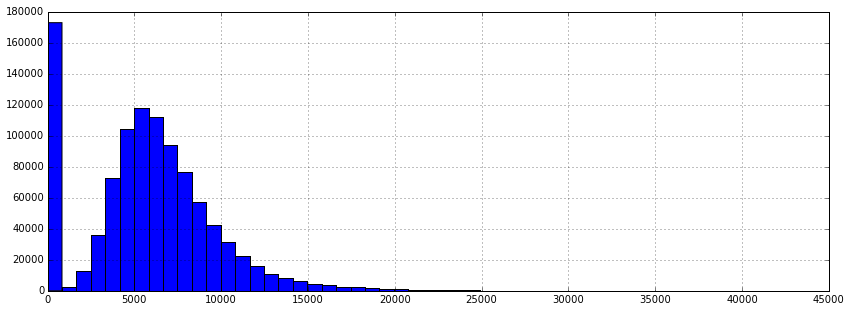

In [25]:
train.Sales.hist(bins=50, figsize=(14, 5))

In [29]:
# Percentage of zero Sales -- 17%  !!!
float(len(train.loc[train.Sales == 0])) / len(train)

0.16994639253093513

## Prepare the data

In [30]:
test.fillna(1, inplace=True)
train = train.loc[train["Open"] != 0]

In [31]:
# merge datasets with Stores data
train = pd.merge(train, stores, on='Store')
test = pd.merge(test, stores, on='Store')

### 1. Feature engineering

In [32]:
def build_features(data):
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1

    dates = pd.DatetimeIndex(data.Date)
    data['Day'] = data.Date.apply(lambda x: x.day)
    data['Month'] = data.Date.apply(lambda x: x.month)
    data['Year'] = data.Date.apply(lambda x: x.year)
    data['WeekOfYear'] = data.Date.apply(lambda x: x.weekofyear)
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)

    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / float(4)
    data['PromoOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)

    data['p_1'] = data.PromoInterval.apply(lambda x: x[:3] if type(x) == str else 0)
    data['p_2'] = data.PromoInterval.apply(lambda x: x[4:7] if type(x) == str else 0)
    data['p_3'] = data.PromoInterval.apply(lambda x: x[8:11] if type(x) == str else 0)
    data['p_4'] = data.PromoInterval.apply(lambda x: x[12:15] if type(x) == str else 0)
    

In [33]:
build_features(train)
build_features(test)

In [34]:
train = train.loc[train["Sales"] != 0]

In [35]:
train.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Day                                   int64
Month                                 int64
Year                                  int64
WeekOfYear                            int64
CompetitionOpen                 

In [36]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['StateHoliday', 'StoreType', 'Assortment', 'p_1', 'p_2', 'p_3', 'p_4']:
    train[c] = lbl_enc.fit_transform(train[c])
    test[c] = lbl_enc.transform(test[c])

In [90]:
# Choose columns
features = list(train.columns)
[features.remove(c) for c in ['Sales', 'Date', 'Customers', 'PromoInterval', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'Promo2SinceWeek']]
print "Features: "
print features

Features: 
['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Day', 'Month', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'p_1', 'p_2', 'p_3', 'p_4']


In [91]:
train[features].columns

Index([u'Store', u'DayOfWeek', u'Open', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'Promo2', u'Day', u'Month', u'Year', u'WeekOfYear', u'CompetitionOpen',
       u'PromoOpen', u'p_1', u'p_2', u'p_3', u'p_4'],
      dtype='object')

## Train XGBoost and predict sales 

In [85]:
# Thanks to Chenglong Chen for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### 0. Select KBest with RF

In [92]:
train[['CompetitionDistance', 'CompetitionOpen', 'PromoOpen']] = \
train[['CompetitionDistance', 'CompetitionOpen', 'PromoOpen']].astype(np.int64) 

In [93]:
x_train = train.loc[train.Date < np.datetime64('2015-06-01T00:00:00.000000000+0000')]
x_cv = train.loc[train.Date >= np.datetime64('2015-06-01T00:00:00.000000000+0000')]
y_train = x_train.Sales
y_cv = x_cv.Sales
x_train = x_train[features]
x_cv = x_cv[features]

In [94]:
x_train.dtypes

Store                  int64
DayOfWeek              int64
Open                   int64
Promo                  int64
StateHoliday           int64
SchoolHoliday          int64
StoreType              int64
Assortment             int64
CompetitionDistance    int64
Promo2                 int64
Day                    int64
Month                  int64
Year                   int64
WeekOfYear             int64
CompetitionOpen        int64
PromoOpen              int64
p_1                    int64
p_2                    int64
p_3                    int64
p_4                    int64
dtype: object

In [96]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)
pred_sales = clf.predict(x_cv)

rmspe(y_cv, pred_sales)

0.1539020059240743

In [107]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

kbest = SelectKBest(k=13)
pipe = Pipeline([('kbest', kbest), ('clf', clf)])
pipe.fit(x_train, y_train)
sales_kbest = pipe.predict(x_cv)

rmspe(y_cv, sales_kbest)

0.18460280848591698

### 1. Check XGB score 

In [109]:
# Set params

params = {"objective": "reg:linear",
          "booster": "gbtree",
          "eta": 0.02,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 3000
stop = 20

In [111]:
# X_train, X_test = cross_validation.train_test_split(train, test_size=0.0118)
dtrain = xgb.DMatrix(x_train.values, np.log(y_train + 1))
dvalid = xgb.DMatrix(x_cv.values, np.log(y_cv + 1))
dtest = xgb.DMatrix(test[features].as_matrix())
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=stop, feval=rmspe_xg, verbose_eval=True)

Will train until train error hasn't decreased in 20 rounds.
[0]	eval-rmspe:0.999844	train-rmspe:0.999837
[1]	eval-rmspe:0.999787	train-rmspe:0.999779
[2]	eval-rmspe:0.999723	train-rmspe:0.999711
[3]	eval-rmspe:0.999649	train-rmspe:0.999635
[4]	eval-rmspe:0.999565	train-rmspe:0.999547
[5]	eval-rmspe:0.999469	train-rmspe:0.999447
[6]	eval-rmspe:0.999360	train-rmspe:0.999333
[7]	eval-rmspe:0.999235	train-rmspe:0.999204
[8]	eval-rmspe:0.999096	train-rmspe:0.999060
[9]	eval-rmspe:0.998939	train-rmspe:0.998897
[10]	eval-rmspe:0.998764	train-rmspe:0.998714
[11]	eval-rmspe:0.998568	train-rmspe:0.998510
[12]	eval-rmspe:0.998349	train-rmspe:0.998282
[13]	eval-rmspe:0.998105	train-rmspe:0.998028
[14]	eval-rmspe:0.997835	train-rmspe:0.997747
[15]	eval-rmspe:0.997535	train-rmspe:0.997435
[16]	eval-rmspe:0.997204	train-rmspe:0.997090
[17]	eval-rmspe:0.996838	train-rmspe:0.996710
[18]	eval-rmspe:0.996437	train-rmspe:0.996292
[19]	eval-rmspe:0.995998	train-rmspe:0.995834
[20]	eval-rmspe:0.995517	train

In [48]:
# Validate predictions
train_probs = gbm.predict(xgb.DMatrix(X_test[features].as_matrix()))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('error', error)

('error', 0.10810610696646081)


In [49]:
#Make predictions on the test set
test_probs = gbm.predict(xgb.DMatrix(test[features].as_matrix()))
indices = test_probs < 0
test_probs[indices] = 0

In [50]:
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("submit.csv", index=False)